Final Report
==================================

Predicting Prices of Airbnb
==================================
***DataMiracle***

**Author:** *Zhongli Wang （18-745-026）, Junlei Chen （18-744-847）, Xingshi Huang （18-743-666）, Qiaoxiao Ren （17-704-933）*


# Introduction of the Project

The sharing economy is playing an increasingly important role in recent years. Set up in 2008, Airbnb works as a platform for hosting and booking and has been offering convenience to both travelers and local people.

To explore which factors may contribute to the price of the provided houses on the platform, we focus on Airbnb US Data. The original dataset was downloaded on May 17th, 2019.

-----------------------------

Table of Contents
==================
* Dataset Description
* Exploratory Data Analysis
  * Numerical Variable
  * Categoric Variable
  * Bianry Variables
  * Missing Value Checking
* Data Pre-Processing
* Training/test set split
* Non-Neuro Network Model: Lasso Linear Regression
* Neuro Network Model: Single Layer Linear Regression 
* Comparing the Fitting Effect of Three Models
* Tensorflow DNN Regressor 
* Further Discussion
* Summary
------------------------------------


## Dataset Description

The data set we use for training neuro network models is downloaded from https://www.kaggle.com/stevezhenghp/airbnb-price-prediction. This is a dataset consists of information on different features of accommodations from Airbnb in several main cities in the U.S. <br/>

It is a 74.1k×29 sized data frame. The features are listed as follows: <br/>

* id (numeric, to identify different listings)
* log_price (numeric, log price per day)
* property_type (string, whether the room is in an apartment or house, etc.)
* room_type (string, whether the room is private or to be shared, etc.)
* amenities (string, the basic and additional amenities offered by host)
* accommodates (numeric, the maximum number of persons can live in)
* bathrooms (numeric, number of bathrooms offered)
* bed_type (string, whether the bed is single or double bed, etc.)
* cancellation_policy (string, whether this accommodation is easy to cancel, etc.)
* cleaning_fee (boolean variable, whether the cleaning fee is required)
* city (string, where the room is located)
* description (string, general description of the room)
* first_review (date variable, first review that was given)
* host_has_profile_pic (boolean variable, whether the host has profile picture)
* host_identity_verified (boolean varianble, whether the host identity is verified)
* host_response_rate (numeric)
* host_since (date variable)
* instant_bookable (boolean variable)
* last_review (date variable, when the last review is written)
* latitude (numeric)
* longitude (numeric)
* name (string)
* neighbourhood (string, description of neighborhood environment)
* number_of_reviews (numeric, number of reviews got from clients)
* review_scores_rating (numeric, rating scores that the host got from clients)
* thumbnail_url (URL)
* zipcode (numeric, zip code from where the room is located)
* bedrooms (numeric, number of bedrooms offered)
* beds (numeric, number of beds offered)<br/>

The main goal we would like to achieve is to predict the price of Airbnb accommodates by using regression models. We would like to compare the non-neural network model to the neural network model. By examining features like location, city, bedroom number, etc., we would like to construct a model that can predict a reasonable price for a new Airbnb host if one wants to make a new listing online. Also, we would like to see which features are rather important at determining the price for a listing.

The six main tunings we apply are shown below:
* The test size. We set the test size as 0.3 and compare the models under this condition.
* Data normalization. Since the label log_price has been the logarithm, we just make adjustments on the important features. For example, we set "bathrooms", "beds", etc as float64 values and extract the boolean variables "TV", "Internet", etc. from "amenities".
* The quantity of epochs. After trial and error, we found that after 25 epochs of training, the loss in the neural network no longer decreases, so we set the quantity of epochs as 25 to compare the models.
* The optimizer. The results with "Adam" and with "rms" are compared in the neural network model.
* The learning rate. Three situations with a rate of 0.1, 0.001 and 0.0001 are compared.
* The alpha of Lasso in model1. Knowing that a very small alpha (for example, 1e-6) would cause loss in information, we choose 1e-4 as the alpha.


## Exploratory Data Analysis

In [80]:
import numpy as np
from numpy.random import seed
seed(123)
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [81]:
sample1 = pd.read_csv("America_airbnb_train1.csv",
                    header=None, sep=",", error_bad_lines=False)

df = pd.DataFrame(sample1)

In [82]:
# We set the header of the table. 
df1 = df.rename(columns=df.iloc[0])
df1 = df1.drop(df.index[0])


### Numerical variable

#### Host_since and first_review

In [83]:
# Converting to datetime
df1.host_since = pd.to_datetime(df1.host_since)
df1.first_review = pd.to_datetime(df1.first_review)
print(min(df1.host_since).strftime('%d %B %Y'))
print(max(df1.host_since).strftime('%d %B %Y'))     

03 March 2008
04 October 2017


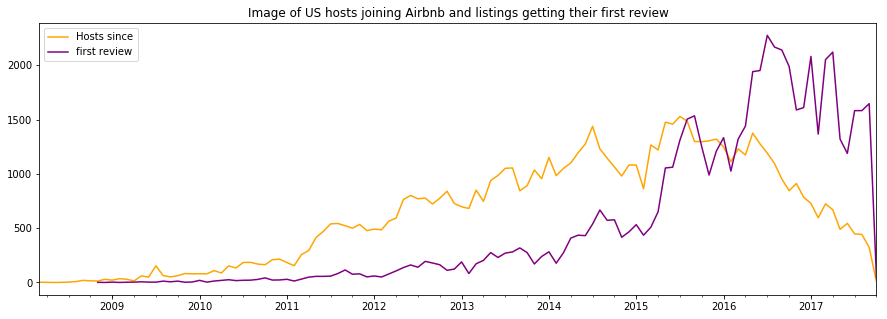

In [84]:
# display the time trend of host_since and first review
plt.figure(figsize=(15,5))
df1.set_index('host_since').resample('MS').size().plot(label='Hosts since', color='orange')
df1.set_index('first_review').resample('MS').size().plot(label='first review', color='purple')
plt.title('Image of US hosts joining Airbnb and listings getting their first review')
plt.legend()
plt.xlim('2008-03-01', '2017-10-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In our dataset, the oldest Airbnb host is from March 2008. Starting from 2014, the new host increased significantly until 2016. The reason could be a ban on short-term rentals on home-sharing sites signed by New York city governors in October 2016. The majority of data in our dataset are from New York City.

#### Price change and Price distribution

Text(0, 0.5, 'Price(log transformed)')

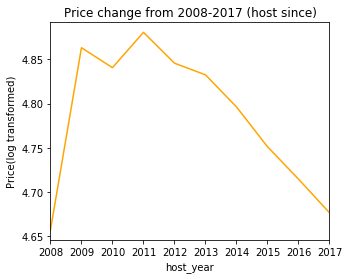

In [93]:
## convert the log_price to float
df1.log_price = df1.log_price.astype("float64")
## generate a new column indicating the year of host
df1["host_year"] = df1.host_since.dt.year
## plot a line figure of host year and price
fig, ax = plt.subplots(figsize=(5,4))
df1.groupby(['host_year']).mean()['log_price'].plot(color = "orange",ax=ax)
plt.title('Price change from 2008-2017 (host since)')
plt.ylabel("Price(log transformed)")


Generally, the image above displays that the older the Airbnb is, the higher the price except for the year 2008. And those starting their Airbnb business from 2011 rank the top in our graph.

Skewness: 0.514695
Kurtosis: 0.660608


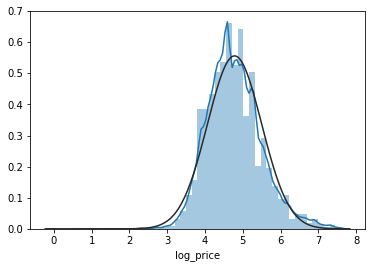

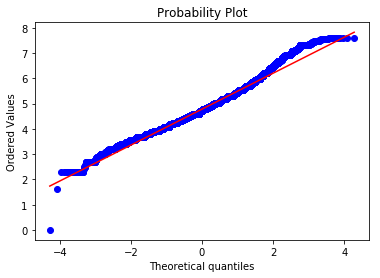

In [94]:
sns.distplot(df1['log_price'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(df1['log_price'], plot=plt)
print("Skewness: %f" % df1['log_price'].skew())
print("Kurtosis: %f" % df1['log_price'].kurt())

From the probability plot, we know that the ordered values are positively correlated with the theoretical quantiles. It offers the intuition that we have the possibility to fit the values into a reasonable range and do data fitting.



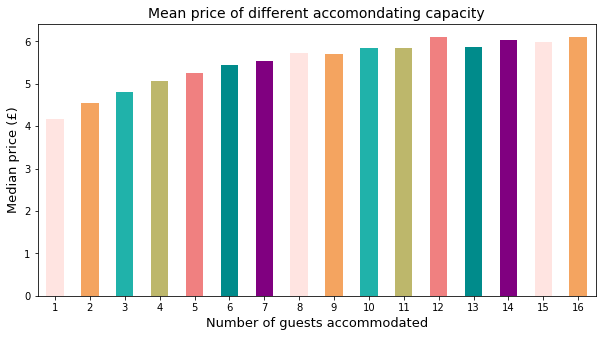

In [95]:
df1.accommodates = df1.accommodates.astype("int64")
plt.figure(figsize=(10,5))
df1.groupby('accommodates').log_price.mean().plot(kind='bar',color = ['mistyrose','sandybrown','lightseagreen','darkkhaki','lightcoral','darkcyan','purple'])
plt.title('Mean price of different accomondating capacity', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.show()

Honestly, more accommodating capacity has a very limited impact on the price of Airbnbs. From 8 people onward, the logarithm of the price is stable at around 5.5. We suggest that if you want to travel in the US, ask your friends to accompany you will be economically efficient.

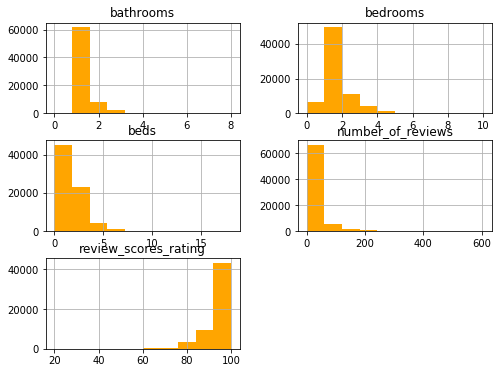

In [96]:
df1.bathrooms = df1.bathrooms.astype("float64")
df1.beds = df1.beds.astype("float64")
df1.bedrooms = df1.bedrooms.astype("float64")
df1.number_of_reviews = df1.number_of_reviews.astype("float64")
df1.review_scores_rating = df1.review_scores_rating.astype("float64")
df1[[ 'bathrooms', 'bedrooms', 'beds',"review_scores_rating","number_of_reviews"]].hist(figsize=(8,6),color = ["orange"]);





The above images show the number of different columns. Most Airbnbs have 2 bedrooms, 1 bathroom, and 1 bed. Interestingly, a large number of Airbnbs have 0 reviews and a majority has 100 scores. We are not sure if the Airbnb has a rule that if the customers don't give a review for several periods, the system will automatically score it 100. To keep our analysis concise and precise, we decide to delete the "number of review" column in the data preprocessing phase.

### Categoric Variable

#### City


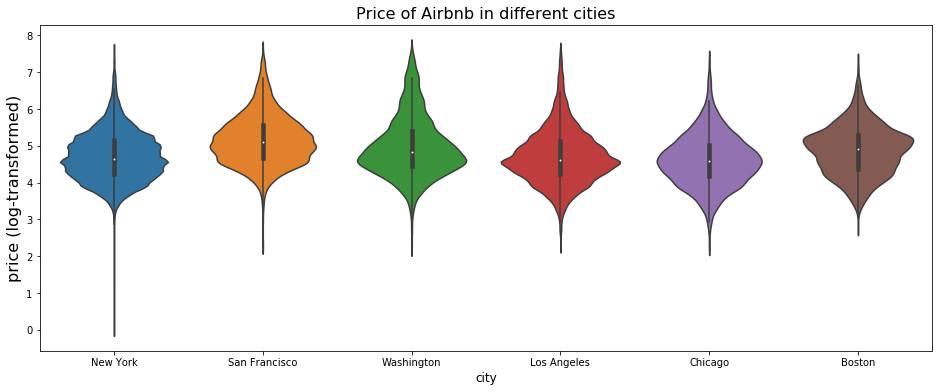

In [97]:
df1["city"] = df1["city"].replace("LA","Los Angeles")
df1["city"] = df1["city"].replace("DC","Washington")
df1["city"] = df1["city"].replace("NYC","New York")
df1["city"] = df1["city"].replace("SF","San Francisco")    
plt.figure(figsize=(16,6))
sns.violinplot(df1.city, df1.log_price)
plt.xlabel('city', fontsize=12)
plt.ylabel('price (log-transformed)', fontsize=16)
plt.title('Price of Airbnb in different cities', fontsize=16)
plt.show()

Price doesn't vary much across different cities. The highest median price is in San Francisco. One of the highest living expense cities, New York, surprisingly provides a competitive Airbnb price (compatible to other places).

Next, we will concentrate on New York cities:

In [85]:
df3 = df1
NY = df3[df3.city=="New York"]


In [86]:
# Importing the boundary GeoJSON file as a dataframe in geopandas
import geopandas as gpd

## download the geojson file from insideairbnb.com under NYC folder
map_df = gpd.read_file('neighbourhoods.geojson')

map_df.head()

neighbourhood neighbourhood_group                                           geometry
0         Bayswater              Queens  (POLYGON ((-73.76670799999999 40.614911, -73.7...
1          Allerton               Bronx  (POLYGON ((-73.848597 40.87167, -73.845823 40....
2       City Island               Bronx  (POLYGON ((-73.782822 40.843919, -73.782572 40...
3  Ditmars Steinway              Queens  (POLYGON ((-73.90160299999999 40.76777, -73.90...
4        Ozone Park              Queens  (POLYGON ((-73.83754399999999 40.691364, -73.8...

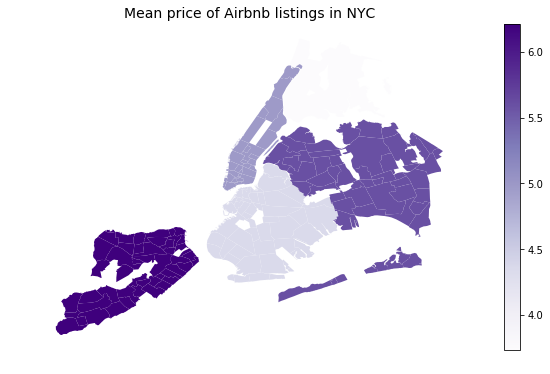

In [22]:
# Creating a dataframe of listing counts and median price by borough
borough_NY = pd.DataFrame(NY.groupby('neighbourhood').size())
# borough_NY.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_NY['mean_price'] = NY.groupby('neighbourhood').log_price.mean().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_NY)

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='neighbourhood_group', cmap='Purples', ax=ax2)
ax2.axis('off')
ax2.set_title('Mean price of Airbnb listings in NYC', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=min(borough_map_df.mean_price), vmax=max(borough_map_df.mean_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()


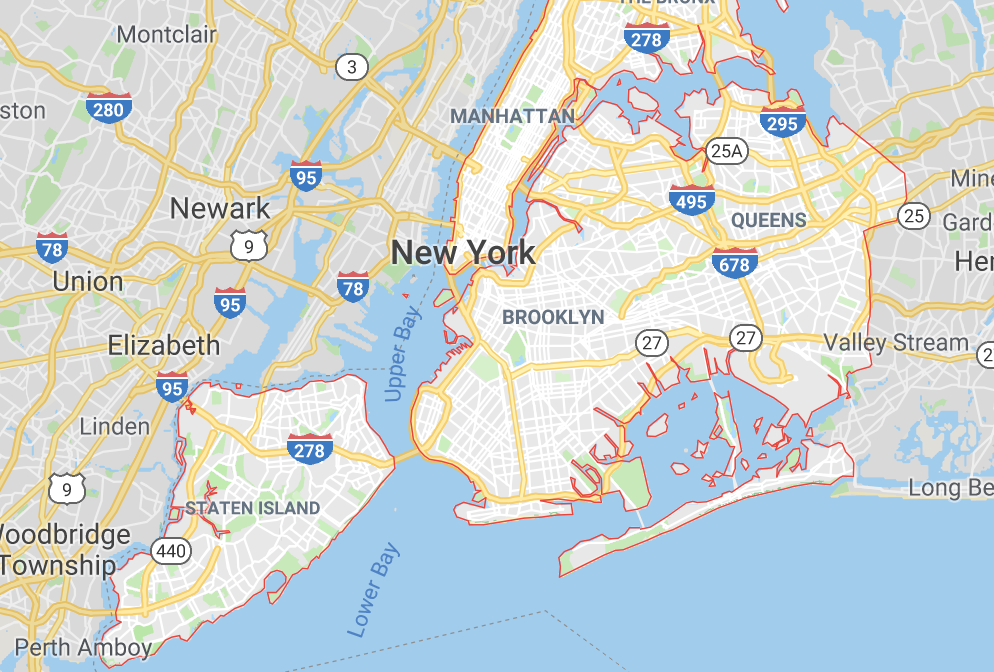
The darker the color, the higher the mean price. Compare to the real map, the most expensive Airbnbs are in Staten Island. We think this is very abnormal (Manhattan should be the highest!!). A possible reason is that the number of Airbnb may not be balanced across NYC. To test this, we then sort the top 100 expensive data out and plot them on a map.



In [26]:
from geopy.geocoders import Nominatim
address = 'New York'
geolocator = Nominatim(user_agent="US_explorer")
location = geolocator.geocode('New York')
NY_latitude = location.latitude
NY_longitude = location.longitude
print('The geograpical coordinates of NY are {}, {}.'.format(NY_latitude, NY_longitude))

The geograpical coordinates of NY are 40.7127281, -74.0060152.


In [71]:
import folium
# # create map of Most Busy Office Areas of Tokyo using latitude and longitude values
NY_map = folium.Map(location=[40.7127281, -74.0060152], zoom_start=12)
NY = df1[df1.city=="NYC"]

In [72]:

NY_sorted = NY.sort_values(by=["log_price"],ascending=False)
NY_sorted = NY_sorted.iloc[0:100,:]

In [79]:
for lat, lng in zip(NY_sorted['latitude'], NY_sorted['longitude']):
    label = folium.Popup(parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=9,
        popup=label,
        color='magenta',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(NY_map) 

NY_map.save("NY.html")

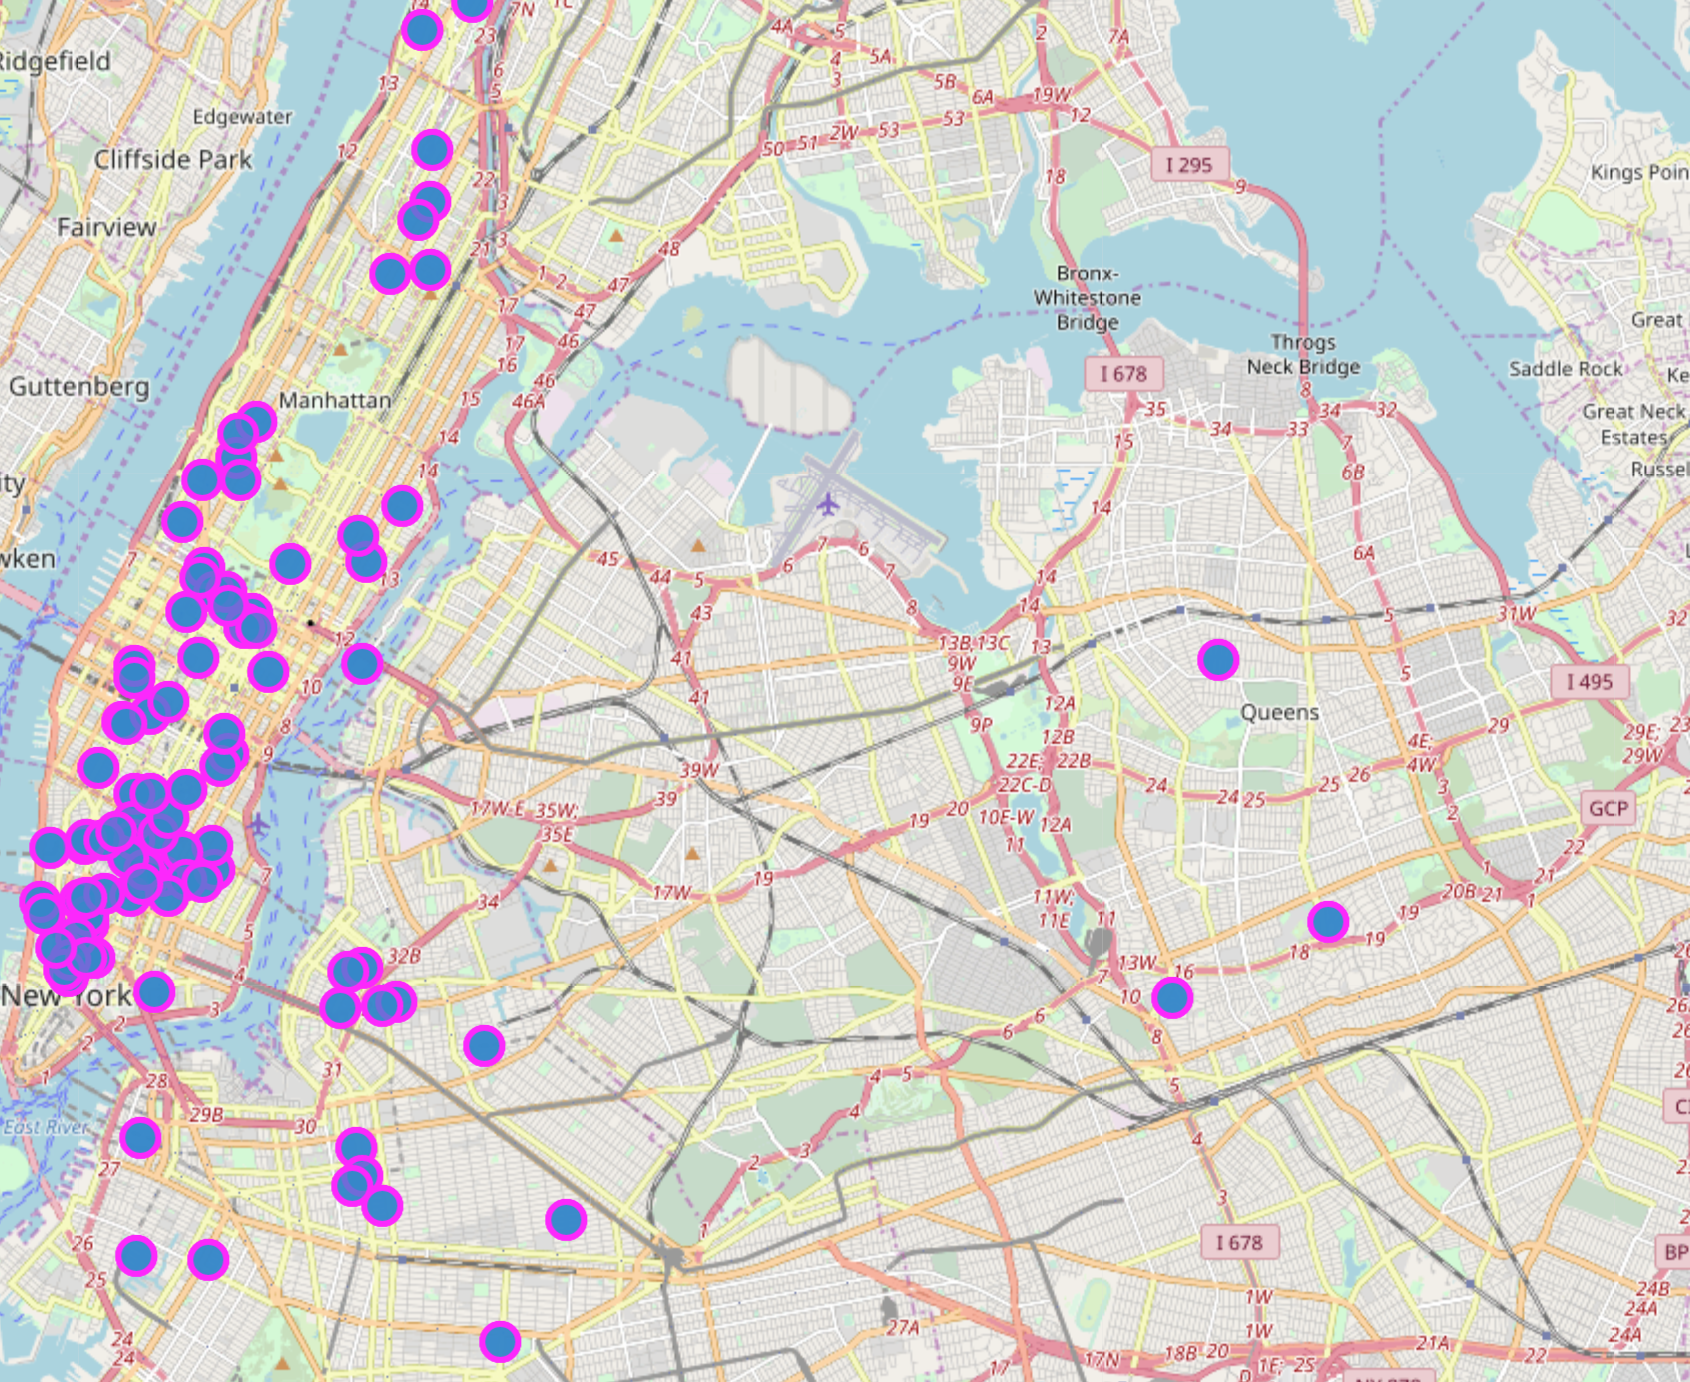

This result makes more sense. Most of the highest price Airbnbs are located around Manhattan which is in line with our normal economic rules.

In [30]:
df1.property_type.value_counts()

Apartment             49003
House                 16511
Condominium            2658
Townhouse              1692
Loft                   1244
Other                   607
Guesthouse              498
Bed & Breakfast         462
Bungalow                366
Villa                   179
Dorm                    142
Guest suite             123
Camper/RV                94
Timeshare                77
Cabin                    72
In-law                   71
Hostel                   70
Boutique hotel           69
Boat                     65
Serviced apartment       21
Tent                     18
Castle                   13
Vacation home            11
Yurt                      9
Hut                       8
Treehouse                 7
Chalet                    6
Earth House               4
Tipi                      3
Train                     2
Cave                      2
Island                    1
Lighthouse                1
Casa particular           1
Parking Space             1
Name: property_type,

In [31]:
df1a = df1.loc[df1["property_type"] == "Apartment"]
df1b = df1.loc[df1["property_type"] == "House"]
df1c = df1.loc[df1["property_type"] == "Condominium"]
df1d = df1.loc[df1["property_type"] == "Townhouse"]
df1e = df1.loc[df1["property_type"] == "Loft"]
#%%
frames = [df1a, df1b, df1c, df1d, df1e]
df1 = pd.concat(frames)

In [32]:
def bar_plot(col, figsize=(7,4)):
    
    plt.figure(figsize=figsize)
    df1[col].value_counts().plot(kind='bar',color = ["orange","purple","lightseagreen"])
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

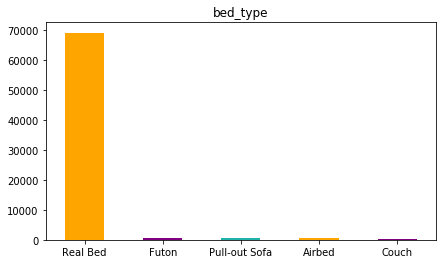

Real Bed         69128
Futon              715
Pull-out Sofa      555
Airbed             460
Couch              250
Name: bed_type, dtype: int64


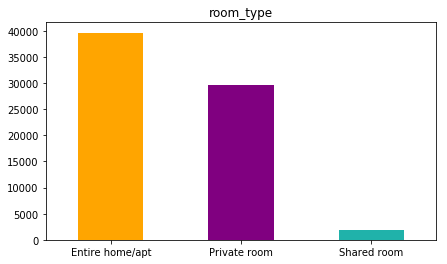

Entire home/apt    39621
Private room       29550
Shared room         1937
Name: room_type, dtype: int64


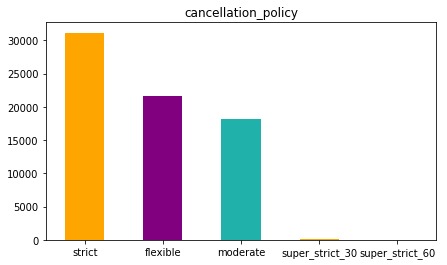

strict             31119
flexible           21633
moderate           18232
super_strict_30      112
super_strict_60       12
Name: cancellation_policy, dtype: int64


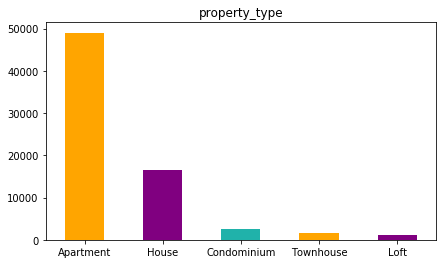

Apartment      49003
House          16511
Condominium     2658
Townhouse       1692
Loft            1244
Name: property_type, dtype: int64


In [24]:
for col in ["bed_type", "room_type","cancellation_policy","property_type"]:
    bar_plot(col)
    print(df1[col].value_counts(normalize=False))

Almost all Airbnbs in the US provide real beds. And room types are more likely to be entire apartment and private rooms than shared rooms. Common property types are apartment and house. Very few will have extremely cancellation policy. 

Small reminder: heard that some Airbnbs say they provide shared rooms but actually they provide only shared beds (we cannot prove it, just funny anecdote on twitter), so be careful when you want to book a shared room on Airbnb.com.

### Bianry Variables

In [34]:
## bianry variables
## Define a plot function first since we want to plot several variables later
def binary_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df1.groupby(col).size().plot(kind='bar', ax=ax1, color=['orange', 'purple'])
    ax1.set_xticklabels(labels=['0', '1'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df1.groupby(col).log_price.mean().plot(kind='bar', ax=ax2, color=['orange', 'purple'])
    ax2.set_xticklabels(labels=['0', '1'], rotation=0)
    ax2.set_title('Mean price')
    ax2.set_xlabel('')
    
   
    plt.show()

In [35]:
df1['cleaning_fee']=df1['cleaning_fee'].replace('True', '1', regex=True)
df1['cleaning_fee']=df1['cleaning_fee'].replace('False', '0', regex=True)
df1['cleaning_fee'].drop_duplicates
df1['cleaning_fee'] = df1['cleaning_fee'].astype('uint8')
# We also change other important boolean variables into numbers 0 and 1.

df1['cleaning_fee']=df1['cleaning_fee'].replace('True', '1', regex=True)
df1['cleaning_fee']=df1['cleaning_fee'].replace('False', '0', regex=True)
df1['cleaning_fee'].drop_duplicates
df1['cleaning_fee'] = df1['cleaning_fee'].astype('uint8')


df1['host_has_profile_pic']=df1['host_has_profile_pic'].replace('t', '1', regex=True)
df1['host_has_profile_pic']=df1['host_has_profile_pic'].replace('f', '0', regex=True)



df1['host_identity_verified']=df1['host_identity_verified'].replace('t', '1', regex=True)
df1['host_identity_verified']=df1['host_identity_verified'].replace('f', '0', regex=True)


df1['instant_bookable']=df1['instant_bookable'].replace('t', '1', regex=True)
df1['instant_bookable']=df1['instant_bookable'].replace('f', '0', regex=True)


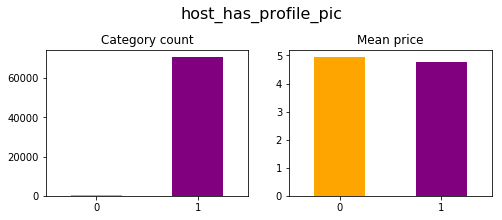

1    70701
0      222
Name: host_has_profile_pic, dtype: int64


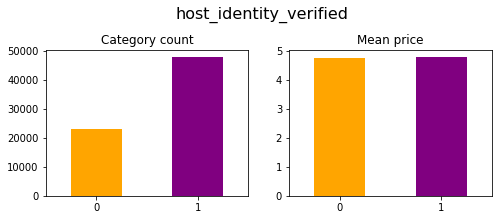

1    47892
0    23031
Name: host_identity_verified, dtype: int64


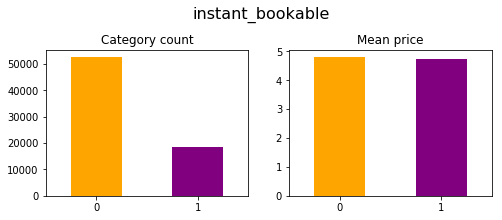

0    52615
1    18493
Name: instant_bookable, dtype: int64


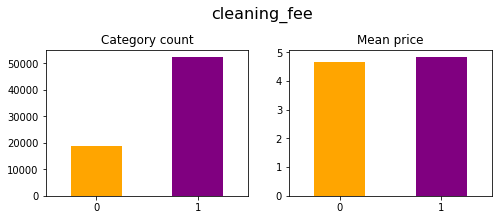

1    52361
0    18747
Name: cleaning_fee, dtype: int64


In [36]:
for col in ["host_has_profile_pic","host_identity_verified","instant_bookable","cleaning_fee"]:
    binary_price_plot(col)
    print(df1[col].value_counts(normalize=False))


Nearly all hosts have a personal picture and those without a picture will have a slightly higher mean price. Instant bookable Airbnbs are less than one-half of not instant bookable ones. While for cleaning fee and host identity verified, the situations reversed. And the mean price is almost identical.

#### Missing Value Checking

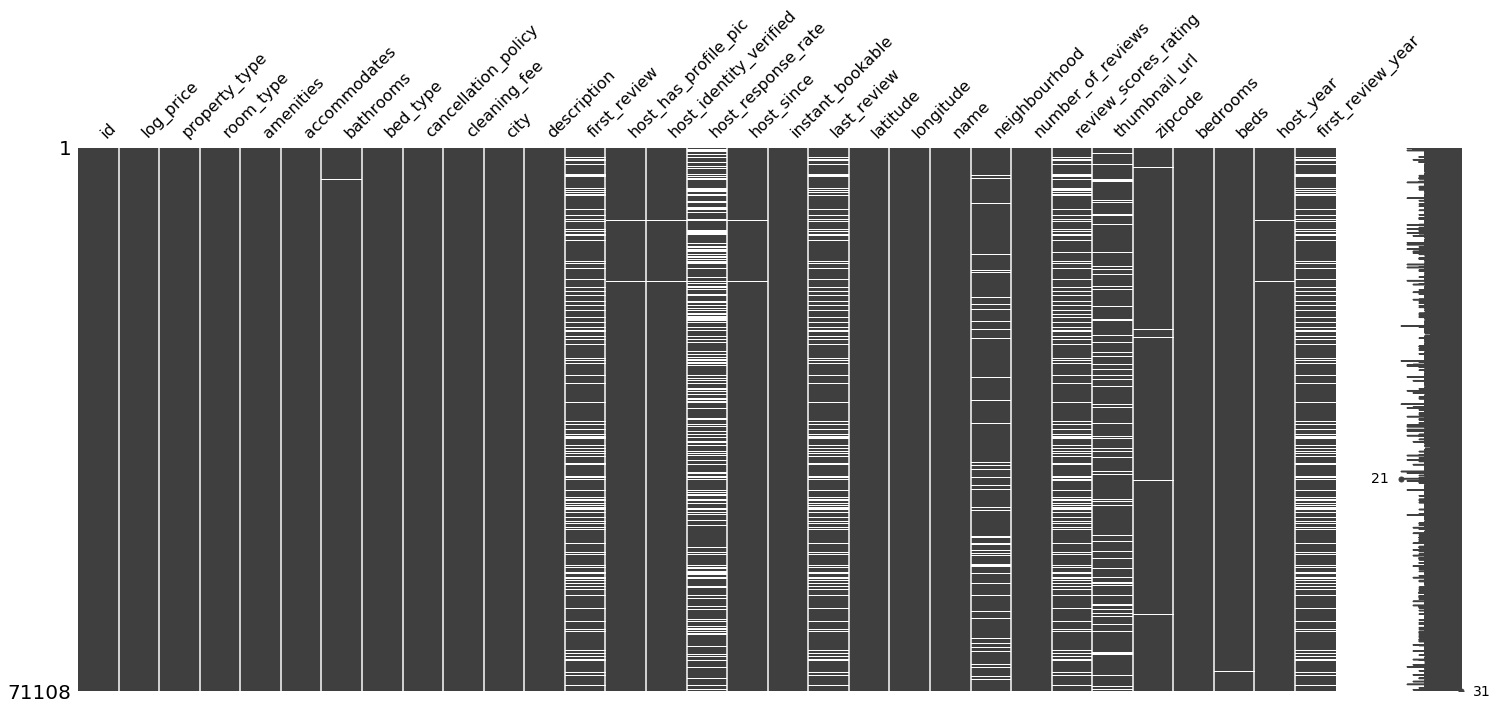

In [38]:
import missingno 
missingno.matrix(df1)

Variables such as host_respose_rate and review_scoring_rating contain too many missing values. Theoretically, the score of the Airbnb and response rate could impact the price a lot. Thus, we are required to find a proper way to substitute them. 

Next, we move to data pre-processing:


## Data pre-processing

Before we feed the data into our model, we did some data pre-processing to transfer the raw data into something understandable for the model. 

First, we dropped the unnecessary features: ‘id’, 'name', 'description', 'thumbnail_url', 'zipcode', 'first_review', 'last_review', 'neighbourhood'. The reasons for that is discussed in the comments of the code. 


In [104]:
# Now we load data.
sample1 = pd.read_csv("America_airbnb_train1.csv",
                    header=None, sep=",", error_bad_lines=False)
print(sample1)
df = pd.DataFrame(sample1)
print(df)

# We set the header of the table. 
df1 = df.rename(columns=df.iloc[0])
df1 = df1.drop(df.index[0])
print(df1)
# As we are going to predict the price of the houses, our label should be 
# log_price, and we can select features from other variables.

# We take the first row data as an example
df1.iloc[0]

# We list some data which we regard as less important data to affect the 
# prices.

# Id and name can be varified.
# Description is hard to be quantified. 
# First_review and last_review are just a simple matter of time.
# Thumbnail_url is just the web address
# Neighbourhood is too varified and can be substituted with zip code.
df1 = df1.drop(['id','name','description','thumbnail_url','zipcode',
                'first_review','last_review','neighbourhood'],axis=1)
print(df1)



             0                   1                2                3                                                  4             5          6              7                    8             9        10                                                 11            12                    13                      14                  15          16                17           18                  19                   20                                                 21                             22                 23                    24                                                 25       26        27    28
0            id           log_price    property_type        room_type                                          amenities  accommodates  bathrooms       bed_type  cancellation_policy  cleaning_fee     city                                        description  first_review  host_has_profile_pic  host_identity_verified  host_response_rate  host_since  instant_bookable  last_review   

             0                   1                2                3                                                  4             5          6              7                    8             9        10                                                 11            12                    13                      14                  15          16                17           18                  19                   20                                                 21                             22                 23                    24                                                 25       26        27    28
0            id           log_price    property_type        room_type                                          amenities  accommodates  bathrooms       bed_type  cancellation_policy  cleaning_fee     city                                        description  first_review  host_has_profile_pic  host_identity_verified  host_response_rate  host_since  instant_bookable  last_review   

             id           log_price    property_type        room_type                                          amenities accommodates bathrooms       bed_type cancellation_policy cleaning_fee     city                                        description first_review host_has_profile_pic host_identity_verified host_response_rate  host_since instant_bookable last_review            latitude            longitude                                               name                  neighbourhood number_of_reviews review_scores_rating                                      thumbnail_url  zipcode bedrooms beds
1       6901257   5.010635294096256        Apartment  Entire home/apt  {"Wireless Internet","Air conditioning",Kitche...            3       1.0       Real Bed              strict         True      NYC  Beautiful, sunlit brownstone 1-bedroom in the ...   2016-06-18                    t                      t                NaN  2012-03-26                f  2016-07-18  40.696523629970756   -73.

Second, we cleaned the data with dropping all the duplicated data rows. 

In [105]:
sample1_city = df1[['city']].drop_duplicates()
print(sample1_city)

sample1_number_of_reviews = df1[['number_of_reviews']].drop_duplicates()
print(sample1_number_of_reviews)
sample1_review_scores_rating = df1[['review_scores_rating']].drop_duplicates()
print(sample1_review_scores_rating)

# As we are not sure which data must be deleted, we keep all data at this stage.

# Now we try to cleanse the data
# Property type:
sample1_property_type = df1[['property_type']].drop_duplicates()
print(sample1_property_type)
# Room type:
sample1_room_type = df1[['room_type']].drop_duplicates()
print(sample1_room_type)
# Bed type:
sample1_bed_type = df1[['bed_type']].drop_duplicates()
print(sample1_bed_type)
# Cancellation Policy
sample1_cancellation_policy = df1[['cancellation_policy']].drop_duplicates()
print(sample1_cancellation_policy)
# Cleaning Fee
sample1_cleaning_fee = df1[['cleaning_fee']].drop_duplicates()
print(sample1_cleaning_fee)
# City
sample1_city = df1[['city']].drop_duplicates()
print(sample1_city)
# host_has_profile_pic
sample1_host_has_profile_pic = df1[['host_has_profile_pic']].drop_duplicates()
print(sample1_host_has_profile_pic)
# host_identity_verified
sample1_host_identity_verified = df1[['host_identity_verified']].drop_duplicates()
print(sample1_host_identity_verified)
# host_response_rate
sample1_host_response_rate = df1[['host_response_rate']].drop_duplicates()
print(sample1_host_response_rate)
# instant_bookable  
sample1_instant_bookable = df1[['instant_bookable']].drop_duplicates()
print(sample1_instant_bookable)
# null values
df1.isnull().sum()

       city
1       NYC
4        SF
5        DC
7        LA
16  Chicago
18   Boston
      number_of_reviews
1                     2
2                     6
3                    10
4                     0
5                     4
6                     3
7                    15
8                     9
9                   159
11                   82
12                   29
14                   13
18                   12
19                   26
20                    5
22                   57
23                   73
26                   14
27                    1
30                   40
33                  248
34                   46
36                   17
37                  138
38                   11
43                   44
50                   34
51                   85
53                   18
57                   31
69                   30
74                   19
76                   25
82                   22
100                  23
102                  28
104                   7
105 

      cleaning_fee
1             True
17           False
32768         True
32770        False
       city
1       NYC
4        SF
5        DC
7        LA
16  Chicago
18   Boston
    host_has_profile_pic
1                      t
93                   NaN
150                    f
   host_identity_verified
1                       t
2                       f
93                    NaN
      host_response_rate
1                    NaN
2                   100%
19                   71%
30                   68%
31                   67%
32                   83%
35                   50%
36                   90%
38                   86%
59                   92%
66                   82%
74                   80%
82                   89%
136                  93%
141                  99%
149                   0%
201                  88%
204                  96%
207                  70%
209                  94%
217                  91%
220                  25%
286                  95%
319              

log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
latitude                      0
longitude                     0
number_of_reviews             0
review_scores_rating      16722
bedrooms                     91
beds                        131
dtype: int64

For feature ‘amenities’, we identified the most frequently displayed amenity types: ‘TV’, ‘Internet’, ‘Air conditioning’, ‘Kitchen’, ‘Heating’, ‘Smoke detector’, ‘Dryer’, ‘Washer’, ‘Hair dryer’, ‘Gym’, ‘Pets allowed’, and ‘Family/kid friendly’. These features are identified as new features for our model. 

In [106]:
# amenities
sample1_amenities = df1[['amenities']].drop_duplicates()
print(sample1_amenities)
# Digging into the items of amenities
df1['TV'] = df1['amenities'].str.contains('TV')
df1['Internet'] = df1['amenities'].str.contains('Internet')
df1['Air conditioning'] = df1['amenities'].str.contains('Air conditioning')
df1['Kitchen'] = df1['amenities'].str.contains('Kitchen')
df1['Heating'] = df1['amenities'].str.contains('Heating')
df1['Smoke detector'] = df1['amenities'].str.contains('Smoke detector')
df1['Dryer'] = df1['amenities'].str.contains('Dryer')
df1['Washer'] = df1['amenities'].str.contains('Washer')
df1['Hair dryer'] = df1['amenities'].str.contains('Hair dryer')
df1['Gym'] = df1['amenities'].str.contains('Gym')
df1['Pets allowed'] = df1['amenities'].str.contains('Pets allowed')
df1['Family/kid friendly'] = df1['amenities'].str.contains('Family/kid friendly')

print(df1['Heating'])

# Show the types of data
df1.dtypes

# Change all items of amenities from boolean to integer.
df1['TV'] = df1['TV'].astype('uint8')
df1['Internet'] = df1['Internet'].astype('uint8')
df1['Air conditioning'] = df1['Air conditioning'].astype('uint8')
df1['Kitchen'] = df1['Kitchen'].astype('uint8')
df1['Heating'] = df1['Heating'].astype('uint8')
df1['Smoke detector'] = df1['Smoke detector'].astype('uint8')
df1['Dryer'] = df1['Dryer'].astype('uint8')
df1['Washer'] = df1['Washer'].astype('uint8')
df1['Hair dryer'] = df1['Hair dryer'].astype('uint8')
df1['Gym'] = df1['Gym'].astype('uint8')
df1['Pets allowed'] = df1['Pets allowed'].astype('uint8')
df1['Family/kid friendly'] = df1['Family/kid friendly'].astype('uint8')

                                               amenities
1      {"Wireless Internet","Air conditioning",Kitche...
2      {"Wireless Internet","Air conditioning",Kitche...
3      {TV,"Cable TV","Wireless Internet","Air condit...
4      {TV,"Cable TV",Internet,"Wireless Internet",Ki...
5      {TV,Internet,"Wireless Internet","Air conditio...
6      {TV,"Wireless Internet",Heating,"Smoke detecto...
7      {TV,Internet,"Wireless Internet","Air conditio...
8      {TV,"Cable TV","Wireless Internet","Wheelchair...
9      {TV,"Cable TV","Wireless Internet","Pets live ...
10     {"Wireless Internet","Air conditioning",Kitche...
11     {Internet,"Wireless Internet","Air conditionin...
12     {TV,"Cable TV",Internet,"Wireless Internet",Ki...
13     {TV,Internet,"Wireless Internet",Kitchen,"Free...
14     {TV,"Cable TV",Internet,"Wireless Internet","A...
15     {Kitchen,Heating,"Smoke detector","Carbon mono...
16     {Internet,"Wireless Internet","Air conditionin...
17     {TV,"Wireless Internet",

1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9         True
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24        True
25        True
26        True
27       False
28        True
29        True
30        True
31        True
32       False
33        True
34        True
35        True
36        True
37        True
38        True
39        True
40        True
41        True
42        True
43        True
44        True
45        True
46        True
47        True
48        True
49        True
50        True
51        True
52        True
53       False
54        True
55        True
56        True
57        True
58        True
59        True
60        True
61        True
62        True
63        True
64        True
65       False
66        True
67        

Also, we changed the Boolean variables into number 0 and 1 so that we can use them as numeric features to feed into the model.

In [107]:
# We also change other important boolean variables into numbers 0 and 1.

df1['cleaning_fee']=df1['cleaning_fee'].replace('True', '1', regex=True)
df1['cleaning_fee']=df1['cleaning_fee'].replace('False', '0', regex=True)
df1['cleaning_fee'].drop_duplicates
df1['cleaning_fee'] = df1['cleaning_fee'].astype('uint8')

sample1_cleaning_fee = df1[['cleaning_fee']].drop_duplicates()
print(sample1_cleaning_fee)

df1['host_has_profile_pic']=df1['host_has_profile_pic'].replace('t', '1', regex=True)
df1['host_has_profile_pic']=df1['host_has_profile_pic'].replace('f', '0', regex=True)

sample1_host_has_profile_pic = df1[['host_has_profile_pic']].drop_duplicates()
print(sample1_host_has_profile_pic)

df1['host_identity_verified']=df1['host_identity_verified'].replace('t', '1', regex=True)
df1['host_identity_verified']=df1['host_identity_verified'].replace('f', '0', regex=True)

sample1_host_identity_verified = df1[['host_identity_verified']].drop_duplicates()
print(sample1_host_identity_verified)

df1['instant_bookable']=df1['instant_bookable'].replace('t', '1', regex=True)
df1['instant_bookable']=df1['instant_bookable'].replace('f', '0', regex=True)

sample1_instant_bookable = df1[['instant_bookable']].drop_duplicates()
print(sample1_instant_bookable)

# Test the data
df1.head()
df1.iloc[0]

print(df1)

    cleaning_fee
1              1
17             0
    host_has_profile_pic
1                      1
93                   NaN
150                    0
   host_identity_verified
1                       1
2                       0
93                    NaN
  instant_bookable
1                0
2                1
                log_price    property_type        room_type                                          amenities accommodates bathrooms       bed_type cancellation_policy  cleaning_fee     city host_has_profile_pic host_identity_verified host_response_rate  host_since instant_bookable            latitude            longitude number_of_reviews review_scores_rating bedrooms beds  TV  Internet  Air conditioning  Kitchen  Heating  Smoke detector  Dryer  Washer  Hair dryer  Gym  Pets allowed  Family/kid friendly
1       5.010635294096256        Apartment  Entire home/apt  {"Wireless Internet","Air conditioning",Kitche...            3       1.0       Real Bed              strict         

Next, we take care of the missing data problem. For feature ‘host_response_rate’, we found 18299 rows were missing this value, so that we dropped this feature and take ‘review_score_rating’ as the substitute. For the feature ‘review_score_rating’, missing values are set as the average of all the other values because this is a rather important feature, and we do want to fill in the missing data with a representative value, which is the mean of all the other values. As we found out that there are at most 200 rows of missing feature data, we ignored those since they make little difference to the whole dataset. 

In [108]:
# After these steps, we could find the amount of N/A data.
df1.isnull().sum()

# We found there are 18299 rows of missing host_response_rate data. We only
# take review_scores_rating as the substitute.
df1 = df1.drop(['host_response_rate'],axis=1)

# NaN of review_scores_rating are set as the average of all other values.
df1['review_scores_rating']=df1['review_scores_rating'].astype('float')


mean_scores=df1['review_scores_rating'].mean()
df1['review_scores_rating']=df1['review_scores_rating'].fillna(mean_scores)

# We found there are at most 200 rows of missing feature data. We ignore those 
# data since they make little difference to the whole sample.
df1=df1.dropna()

df1.iloc[0]

# After these steps, we could find there is no N/A data.
df1.isnull().sum()

log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_since                0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
TV                        0
Internet                  0
Air conditioning          0
Kitchen                   0
Heating                   0
Smoke detector            0
Dryer                     0
Washer                    0
Hair dryer                0
Gym                       0
Pets allowed              0
Family/kid friendly       0
dtype: int64

Besides, we changed the feature ‘host_since’, the date variable, into a duration of time. Therefore, we can better analyze the information provided by the date variable.

In [109]:
# duration
from dateutil import parser
def diff_date_now(row):
    today = parser.parse('2019-6-10')
    return ((today - parser.parse(row['host_since'])).days)/365.25
df1['host_since'] = df1.apply(diff_date_now,axis=1)
df1['host_since'].describe()

df1.iloc[0]

log_price                                                 5.010635294096256
property_type                                                     Apartment
room_type                                                   Entire home/apt
amenities                 {"Wireless Internet","Air conditioning",Kitche...
accommodates                                                              3
bathrooms                                                               1.0
bed_type                                                           Real Bed
cancellation_policy                                                  strict
cleaning_fee                                                              1
city                                                                    NYC
host_has_profile_pic                                                      1
host_identity_verified                                                    1
host_since                                                          7.20602
instant_book

Also, we standardized the feature ‘review_scores_rating’, so that for this important feature we ensure that every value has the same scale unit. And then we convert all the important features into float type.

In [110]:
# Standardize the scores
mean_scores2=df1['review_scores_rating'].mean()
mean_scores2

sigma_scores2=df1['review_scores_rating'].std()
sigma_scores2

df1['review_scores_rating'] = (df1['review_scores_rating'] - mean_scores2)/sigma_scores2

print(df1)
df1.isnull().sum()

                log_price    property_type        room_type                                          amenities accommodates bathrooms       bed_type cancellation_policy  cleaning_fee     city host_has_profile_pic host_identity_verified  host_since instant_bookable            latitude            longitude number_of_reviews  review_scores_rating bedrooms beds  TV  Internet  Air conditioning  Kitchen  Heating  Smoke detector  Dryer  Washer  Hair dryer  Gym  Pets allowed  Family/kid friendly
1       5.010635294096256        Apartment  Entire home/apt  {"Wireless Internet","Air conditioning",Kitche...            3       1.0       Real Bed              strict             1      NYC                    1                      1    7.206023                0  40.696523629970756   -73.99161684624262                 2              0.859777      1.0  1.0   0         1                 1        1        1               0      0       0           1    0             0                    1
2      5.12989

log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_since                0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
TV                        0
Internet                  0
Air conditioning          0
Kitchen                   0
Heating                   0
Smoke detector            0
Dryer                     0
Washer                    0
Hair dryer                0
Gym                       0
Pets allowed              0
Family/kid friendly       0
dtype: int64

Moreover, we used dummy variable method to deal with features such as ‘property_type’, ‘room_type’, ‘bed_type’, ‘cancellation_policy’, and ‘city’. Because of the possibility of multicollinearity, we delete one dummy variable for each of the features. Till now, we have transferred all the important features into numeric variables so that we can feed them into the model.

Skewness: 0.514228
Kurtosis: 0.659197


log_price  accommodates  bathrooms  cleaning_fee  host_has_profile_pic  host_identity_verified  host_since  instant_bookable   latitude   longitude  number_of_reviews  review_scores_rating  bedrooms  beds  TV  Internet  Air conditioning  Kitchen  Heating  Smoke detector  Dryer  Washer  Hair dryer  Gym  Pets allowed  Family/kid friendly  Apartment  Condominium  House  Townhouse  Entire home/apt  Private room  Airbed  Couch  Pull-out Sofa  Real Bed  flexible  moderate  strict  super_strict_30  Boston  DC  LA  NYC  SF
1       5.010635           3.0        1.0             1                     1                       1    7.206023                 0  40.696524  -73.991617                2.0              0.859777       1.0   1.0   0         1                 1        1        1               0      0       0           1    0             0                    1          1            0      0          0                1             0       0      0              0         1         0         0       1                0       0   0   0    1   0
2       5.129899           7.0        1.0             1                     1                       0    1.973990                 1  40.766115  -73.989040                6.0             -0.155991       3.0   3.0   0         1                 1        1        1               1      1       1           1    0             0                    1          1            0      0          0                1             0       0      0              0         1         0         0       1                0       0   0   0    1   0
3       4.976734           5.0        1.0             1                     1                       1    2.622861                 1  40.808110  -73.943756               10.0             -0.301101       1.0   3.0   1         1                 1        1        1               1      0       0           1    0             0                    1          1            0      0          0                1             0       0      0              0         1         0         1       0                0       0   0   0    1   0
5       4.744932           2.0        1.0             1                     1                       1    4.276523                 1  38.925627  -77.034596                4.0             -7.846809       0.0   1.0   1         1                 1        1        1               1      0       0           0    0             0                    0          1            0      0          0                1             0       0      0              0         1         0         1       0                0       0   1   0    0   0
6       4.442651           2.0        1.0             1                     1                       1    2.006845                 1  37.753164 -122.429526                3.0              0.859777       1.0   1.0   1         1                 0        0        1               1      0       0           0    0             0                    0          1            0      0          0                0             1       0      0              0         1         0         0       1                0       0   0   0    0   1
7       4.418841           3.0        1.0             1                     1                       0    2.269678                 1  33.980454 -118.462821               15.0              0.424448       1.0   1.0   1         1                 1        1        1               1      1       1           1    1             0                    1          1            0      0          0                1             0       0      0              0         1         0         1       0                0       0   0   1    0   0
11      4.605170           2.0        1.0             1                     1                       1    6.203970                 0  40.723883  -73.983880               82.0             -0.155991       1.0   1.0   0         1                 1        1        1               1      1       1           1    0  

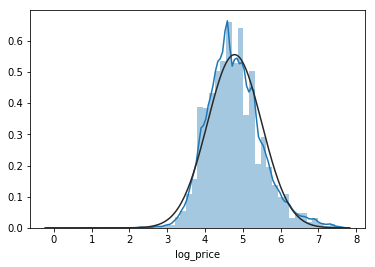

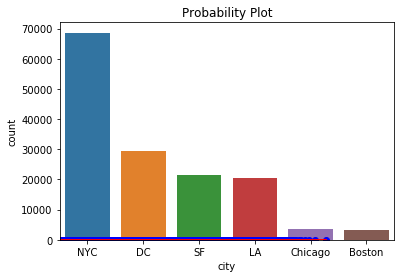

In [111]:
# Convert the important data.
df1['bedrooms']=df1['bedrooms'].astype('float')
df1['bedrooms']
df1['accommodates']=df1['accommodates'].astype('float')
df1['accommodates']
df1['bathrooms']=df1['bathrooms'].astype('float')
df1['bathrooms']
df1['number_of_reviews']=df1['number_of_reviews'].astype('float')
df1['number_of_reviews']
df1['latitude']=df1['latitude'].astype('float')
df1['latitude']
df1['longitude']=df1['longitude'].astype('float')
df1['longitude']
df1['beds']=df1['beds'].astype('float')
df1['beds']
df1['log_price']=df1['log_price'].astype('float')
df1['log_price']
df1['host_has_profile_pic']=df1['host_has_profile_pic'].astype('uint8')
df1['host_identity_verified']=df1['host_identity_verified'].astype('uint8')
df1['instant_bookable']=df1['instant_bookable'].astype('uint8')

# Check if we have converted all important data.
df1.dtypes

df1['log_price'].describe()

sns.distplot(df1['log_price'], fit=norm);
fig = plt.figure()
res = scipy.stats.probplot(df1['log_price'], plot=plt)
print("Skewness: %f" % df1['log_price'].skew())
print("Kurtosis: %f" % df1['log_price'].kurt())

df1['property_type'].describe()
df1['property_type'].value_counts()

df1a = df1.loc[df1["property_type"] == "Apartment"]
df1b = df1.loc[df1["property_type"] == "House"]
df1c = df1.loc[df1["property_type"] == "Condominium"]
df1d = df1.loc[df1["property_type"] == "Townhouse"]
df1e = df1.loc[df1["property_type"] == "Loft"]

frames = [df1a, df1b, df1c, df1d, df1e]
df2 = pd.concat(frames)
df2

sns.countplot(x='property_type',data=df2)
sns.countplot(x='room_type',data=df2)
sns.countplot(x='bed_type',data=df2)
sns.countplot(x='cancellation_policy',data=df2)
sns.countplot(x='city',data=df2)

#get dummies of object variables
df2_property_type=pd.get_dummies(df2['property_type'])
df2_room_type= pd.get_dummies(df2['room_type'])
df2_bed_type = pd.get_dummies(df2['bed_type'])
df2_cancellation_policy = pd.get_dummies(df2['cancellation_policy'])
df2_city = pd.get_dummies(df2['city'])

frames2 = [df2, df2_property_type, df2_room_type, df2_bed_type, df2_cancellation_policy, df2_city]
df3 = pd.concat(frames2,axis=1)

df4 = df3.drop(['property_type','room_type','amenities','bed_type','cancellation_policy',
                'city'],axis=1)

#Drop one dummy for every dummy sector to prevent the multicollinearity
df4 = df4.drop(['Loft','Shared room','Futon','super_strict_60',
                'Chicago'],axis=1)

df4

## Training/test set split

As we have done the data pre-processing, now we shuffle the data to make sure that all the data rows are randomly distributed. And then we create Y as our label variable, log_price, as our goal is to predict the actual price for a listing. Also, we create X to represent our numeric features. Then we set 30% of data as our test set, and the rest as our training set.

In [112]:
from sklearn.utils import shuffle
#shuffle the data - essential
shuffle(df4)

# Y = log_price
Y = df4['log_price']
df4.drop(['log_price'],axis=1,inplace=True)

df4.to_csv('X_new.csv',index=False)
Y.to_csv('Y_new.csv',index=False)

df4 = pd.read_csv('X_new.csv')
df4.head(2)

Y = pd.read_csv('Y_new.csv',header=None)
Y.head(2)

X = df4.values.copy()

X_train, X_val , Y_train, Y_val = train_test_split(df4,Y,test_size=0.3,random_state=101)

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_val)

array([[-0.54051497, -0.41425165,  0.59762087, ...,  1.55798689,
        -0.8981959 , -0.30447661],
       [-0.54051497,  1.3589291 ,  0.59762087, ..., -0.64185392,
         1.11334287, -0.30447661],
       [-1.01104375, -0.41425165,  0.59762087, ..., -0.64185392,
        -0.8981959 , -0.30447661],
       ...,
       [ 1.34160017,  0.47233873,  0.59762087, ...,  1.55798689,
        -0.8981959 , -0.30447661],
       [ 6.04688803, 11.99801358,  0.59762087, ...,  1.55798689,
        -0.8981959 , -0.30447661],
       [ 0.4005426 , -0.41425165,  0.59762087, ..., -0.64185392,
         1.11334287, -0.30447661]])

## Non-Neural Network Model: Lasso Linear regression

Firstly, we use Lasso（Least Absolute Shrinkage and Selection Operator) Linear Regression model to fit the data. We defined R² and Adjusted R² in our code as two standard coefficients of determination to reflect the performance of our model. As we can see from the result:

In [113]:
# Define the R^2 and adjusted R^2
def adj_r2(r2,n,p):
    return 1- ((1-r2)*(n-1))/(n-p-1)

# First we set up a linear model with Lasso.
model1 = Lasso(alpha=1e-4)
model1.fit(X_train,Y_train)

yp_train = model1.predict(X_train)
yp_val = model1.predict(X_val)

train_r2 =(r2_score(Y_train, yp_train))
val_r2 =(r2_score(Y_val, yp_val))
    
print('Train r2= ',train_r2)
print('Test r2= ',val_r2)

train_mse =(mse(Y_train, yp_train))
val_mse =(mse(Y_val, yp_val))
    
print('Train error= ',train_mse)
print('Test error= ',val_mse)

adj_r2(train_r2,X_train.shape[0],X_train.shape[1])

adj_r2(val_r2,X_val.shape[0],X_val.shape[1])

for i in range(len(model1.coef_)):
    print(df4.columns[i],' ',model1.coef_[i])


Train r2=  0.5784542900104608
Test r2=  0.5830841521413049
Train error=  0.2136133752108804
Test error=  0.21769723199092186
accommodates   0.07369004951848415
bathrooms   0.1488158433327153
cleaning_fee   -0.053457341314208186
host_has_profile_pic   -0.06884098475310987
host_identity_verified   -0.04268794373049275
host_since   0.019130426813187947
instant_bookable   -0.0394085740168135
latitude   0.021673320770262273
longitude   -0.015681708784062137
number_of_reviews   -0.0007287629478752639
review_scores_rating   0.03404327301806223
bedrooms   0.14575073328996707
beds   -0.03920218159582316
TV   0.134815751611806
Internet   -0.1101748711971669
Air conditioning   0.03191888455757417
Kitchen   -0.0582523465097192
Heating   0.01676062727278009
Smoke detector   -0.039811864961126986
Dryer   0.07113080609333361
Washer   0.0018344929795486142
Hair dryer   0.015333196590682127
Gym   0.14802212288089953
Pets allowed   -0.0
Family/kid friendly   0.020482748710820266
Apartment   -0.150334890

In model1, we get a pair of train- and test- R squared. Both are approximately 0.58. We also get train- and test- error as about 0.215.

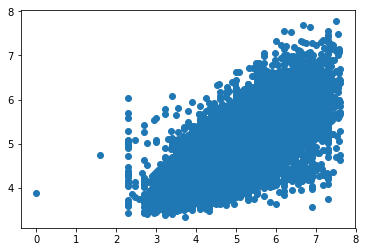

In [114]:
# Now we make a plot of model1.
plt.scatter(Y,model1.predict(X))
plt.show()   

It is obvious that our model shows a positive relationship between the real data and the data we predict. However, we should consider more factors to improve our model. The neural network should be a good example to utilize.

## Neural Network Model: Single Layer Linear regression

The first neural network model we use to fit the model is single layer linear regression. We use the function Sequential( ) from Python package Keras. As discussed in class, we tried to set the Dense as 1, and the number of parameters is 44, which is the same as the number of the features. We would discuss other important parameter tuning process in the following parts.

## Comparing the fitting effect of three models

Lasso helps with “normalizing” the model, but the data in the model are actually not utilized as a neural network. To increase the effectiveness of the trained data, we apply Sequential( ) function and use keras to build the regression model.
One parameter which really matters in this process is the learning rate. According to Goodfellow, Bengio and Courville (2017), we could optimize the learning rate by monitoring the first several iterations and take a learning rate into use, which is higher than the best-performing learning rate at this time, but not so high that it causes severe instability.  Therefore, we try to apply three different learning rates on our model: 0.01, 0.001 and 0.0001. Meanwhile, after trial and error we found that when we set epochs as 25, the loss of the model could be controlled in a relatively appropriate range. We define the three situations model2 (lr=0.01), model2a (lr=0.001) and model2b (lr=0.0001).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1)                 45        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
70603/70603 [==============================] - 6s 90us/step - loss: 2.9429
Epoch 2/25
70603/70603 [==============================] - 6s 79us/step - loss: 1.0495
Epoch 3/25
70603/70603 [==============================] - 5s 65us/step - loss: 1.0440
Epoch 4/25
70603/70603 [==============================] - 4s 61us/step - loss: 1.0454
Epoch 5/25
70603/70603 [==============================] - 4s 59us/step - loss: 1.0441: 1s  - ETA: 0s - loss: 1.043
Epoch 6/25
70603/70603 [==============================] - 4s 61us/step - loss: 1.0444
Epoch 7/25
70603/70603 [==============================] - 4s 59us/step - loss: 1.0400
Epoch 8/25
70603/70603 [===================

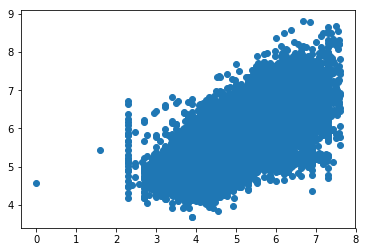

Train on 49422 samples, validate on 21181 samples
Epoch 1/25
49422/49422 [==============================] - 4s 77us/step - loss: 1.0458 - val_loss: 2.2275
Epoch 2/25
49422/49422 [==============================] - 4s 82us/step - loss: 1.0445 - val_loss: 0.4782
Epoch 3/25
49422/49422 [==============================] - 4s 71us/step - loss: 1.0404 - val_loss: 0.2749
Epoch 4/25
49422/49422 [==============================] - 3s 62us/step - loss: 1.0352 - val_loss: 2.0024
Epoch 5/25
49422/49422 [==============================] - 3s 67us/step - loss: 1.0425 - val_loss: 1.8351
Epoch 6/25
49422/49422 [==============================] - 3s 70us/step - loss: 1.0417 - val_loss: 0.2883
Epoch 7/25
49422/49422 [==============================] - 3s 63us/step - loss: 1.0323 - val_loss: 0.8411
Epoch 8/25
49422/49422 [==============================] - 3s 65us/step - loss: 1.0418 - val_loss: 3.3367
Epoch 9/25
49422/49422 [==============================] - 3s 62us/step - loss: 1.0356 - val_loss: 1.2703
Epoch

In [116]:
# Choose an optimizer and compile the model
# In order to find a relatively optimized learning rate, we set learning rate 
# as 0.01, 0.001, 0.0001.
model2 = Sequential()
model2.add(Dense(1, input_shape = (X_train.shape[1],)))
model2.summary()  
rms = keras.optimizers.RMSprop(lr=0.01)
model2.compile(loss='mse', optimizer=rms)
#%%    
model2.fit(X, Y, epochs = 25)
#%%    
model2.get_layer(name='dense_18').get_weights()
#%%
plt.scatter(Y,model2.predict(X))
plt.show()   
#%%
import time
model2_start = time.time()
model2.fit(X_train, Y_train, epochs = 25,validation_data = (X_val,Y_val))
model2_end = time.time()
print(f"Time taken to run: {round((model2_end - model2_start)/60,1)} minutes")

Firstly, we compare the loss in three situations. In model2, we can find that the loss of each epoch should be around 1.04. The computation time of this model should be about 1.4 minutes.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1)                 45        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
70603/70603 [==============================] - 6s 89us/step - loss: 3.2076
Epoch 2/25
70603/70603 [==============================] - 5s 69us/step - loss: 0.2416
Epoch 3/25
70603/70603 [==============================] - 4s 62us/step - loss: 0.2338
Epoch 4/25
70603/70603 [==============================] - 5s 67us/step - loss: 0.2307: 0s - loss
Epoch 5/25
70603/70603 [==============================] - 4s 63us/step - loss: 0.2296
Epoch 6/25
70603/70603 [==============================] - 5s 66us/step - loss: 0.2287
Epoch 7/25
70603/70603 [==============================] - 5s 73us/step - loss: 0.2280
Epoch 8/25
70603/70603 [==============================] - 6s 

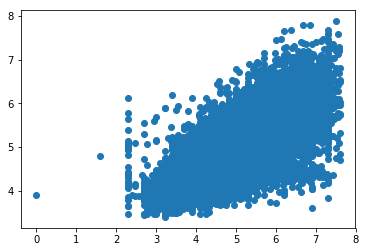

Train on 49422 samples, validate on 21181 samples
Epoch 1/25
49422/49422 [==============================] - 4s 84us/step - loss: 0.2261 - val_loss: 0.2381
Epoch 2/25
49422/49422 [==============================] - 4s 76us/step - loss: 0.2267 - val_loss: 0.2622
Epoch 3/25
49422/49422 [==============================] - 4s 82us/step - loss: 0.2257 - val_loss: 0.2786
Epoch 4/25
49422/49422 [==============================] - 5s 94us/step - loss: 0.2266 - val_loss: 0.2283
Epoch 5/25
49422/49422 [==============================] - 4s 86us/step - loss: 0.2259 - val_loss: 0.2500
Epoch 6/25
49422/49422 [==============================] - 3s 70us/step - loss: 0.2265 - val_loss: 0.2424
Epoch 7/25
49422/49422 [==============================] - 3s 66us/step - loss: 0.2263 - val_loss: 0.2706
Epoch 8/25
49422/49422 [==============================] - 3s 71us/step - loss: 0.2265 - val_loss: 0.2250
Epoch 9/25
49422/49422 [==============================] - 3s 69us/step - loss: 0.2260 - val_loss: 0.2450
Epoch

In [120]:
#%% Now we set learning rate as 0.001
model2a = Sequential()
model2a.add(Dense(1, input_shape = (X_train.shape[1],)))
model2a.summary()  
rms2a = keras.optimizers.RMSprop(lr=0.001)
model2a.compile(loss='mse', optimizer=rms2a)
model2a.fit(X, Y, epochs = 25)
#%%
model2a.get_layer(name='dense_22').get_weights()
#%%
plt.scatter(Y,model2a.predict(X))
plt.show()   
#%%
import time
model2a_start = time.time()
model2a.fit(X_train, Y_train, epochs = 25,validation_data = (X_val,Y_val))
model2a_end = time.time()
print(f"Time taken to run: {round((model2a_end - model2a_start)/60,1)} minutes")

In model 2a, the initial loss should be about 21, while others are around 0.23. We need about 1.7 minutes to compute the model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 1)                 45        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
70603/70603 [==============================] - 7s 103us/step - loss: 15.2018
Epoch 2/25
70603/70603 [==============================] - 5s 74us/step - loss: 0.4926
Epoch 3/25
70603/70603 [==============================] - 5s 76us/step - loss: 0.2978
Epoch 4/25
70603/70603 [==============================] - 5s 71us/step - loss: 0.2460
Epoch 5/25
70603/70603 [==============================] - 5s 68us/step - loss: 0.2297
Epoch 6/25
70603/70603 [==============================] - 5s 77us/step - loss: 0.2239
Epoch 7/25
70603/70603 [==============================] - 5s 76us/step - loss: 0.2221
Epoch 8/25
70603/70603 [==============================] - 6s 79us/step

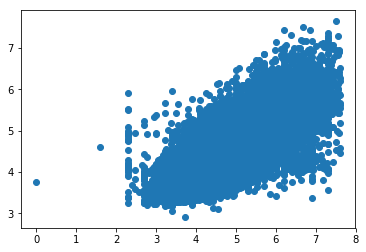

Train on 49422 samples, validate on 21181 samples
Epoch 1/25
49422/49422 [==============================] - 4s 88us/step - loss: 0.2204 - val_loss: 0.2184
Epoch 2/25
49422/49422 [==============================] - 4s 84us/step - loss: 0.2207 - val_loss: 0.2330
Epoch 3/25
49422/49422 [==============================] - 5s 91us/step - loss: 0.2205 - val_loss: 0.2190
Epoch 4/25
49422/49422 [==============================] - 5s 104us/step - loss: 0.2209 - val_loss: 0.2189
Epoch 5/25
49422/49422 [==============================] - 5s 97us/step - loss: 0.2213 - val_loss: 0.2190
Epoch 6/25
49422/49422 [==============================] - 4s 85us/step - loss: 0.2209 - val_loss: 0.2213
Epoch 7/25
49422/49422 [==============================] - 4s 71us/step - loss: 0.2204 - val_loss: 0.2192
Epoch 8/25
49422/49422 [==============================] - 4s 83us/step - loss: 0.2212 - val_loss: 0.2205
Epoch 9/25
49422/49422 [==============================] - 4s 78us/step - loss: 0.2206 - val_loss: 0.2198
Epoc

In [124]:
# Now, to adjust the model, we use 'Adam' optimizer to see the fitting effect. We set the new model as model2a1.
model2a1 = Sequential()
model2a1.add(Dense(1, input_shape = (X_train.shape[1],)))
model2a1.summary()  
model2a1.compile(loss='mse', optimizer="Adam")
model2a1.fit(X, Y, epochs = 25)
#%%
model2a1.get_layer(name='dense_26').get_weights()
#%%
plt.scatter(Y,model2a1.predict(X))
plt.show()  
#%%
import time
model2a1_start = time.time()
model2a1.fit(X_train, Y_train, epochs = 25,validation_data = (X_val,Y_val))
model2a1_end = time.time()
print(f"Time taken to run: {round((model2a1_end - model2a1_start)/60,1)} minutes")

In model2a1, we find that the general loss except the initial loss should be around 0.22. We need about 1.7 minutes to compute the model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1)                 45        
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
70603/70603 [==============================] - 7s 98us/step - loss: 166.9219
Epoch 2/25
70603/70603 [==============================] - 5s 68us/step - loss: 11.2836
Epoch 3/25
70603/70603 [==============================] - 4s 63us/step - loss: 0.5503
Epoch 4/25
70603/70603 [==============================] - 4s 63us/step - loss: 0.3465
Epoch 5/25
70603/70603 [==============================] - 6s 79us/step - loss: 0.2896
Epoch 6/25
70603/70603 [==============================] - 5s 75us/step - loss: 0.2667
Epoch 7/25
70603/70603 [==============================] - 5s 66us/step - loss: 0.2537
Epoch 8/25
70603/70603 [==============================] - 5s 72us/ste

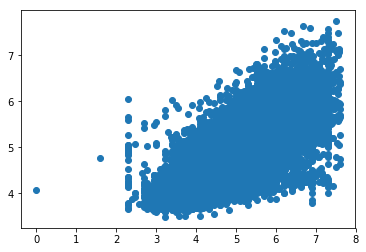

Train on 49422 samples, validate on 21181 samples
Epoch 1/25
49422/49422 [==============================] - 4s 81us/step - loss: 0.2176 - val_loss: 0.2224
Epoch 2/25
49422/49422 [==============================] - 4s 73us/step - loss: 0.2174 - val_loss: 0.2223
Epoch 3/25
49422/49422 [==============================] - 3s 69us/step - loss: 0.2173 - val_loss: 0.2211
Epoch 4/25
49422/49422 [==============================] - 3s 69us/step - loss: 0.2170 - val_loss: 0.2224
Epoch 5/25
49422/49422 [==============================] - 4s 76us/step - loss: 0.2169 - val_loss: 0.2227
Epoch 6/25
49422/49422 [==============================] - 4s 72us/step - loss: 0.2167 - val_loss: 0.2207
Epoch 7/25
49422/49422 [==============================] - 3s 70us/step - loss: 0.2166 - val_loss: 0.2205
Epoch 8/25
49422/49422 [==============================] - 3s 69us/step - loss: 0.2164 - val_loss: 0.2235
Epoch 9/25
49422/49422 [==============================] - 4s 71us/step - loss: 0.2163 - val_loss: 0.2210
Epoch

In [126]:
# Now we set learning rate as 0.0001.
model2b = Sequential()
model2b.add(Dense(1, input_shape = (X_train.shape[1],)))
model2b.summary()  
rms2b = keras.optimizers.RMSprop(lr=0.0001)
model2b.compile(loss='mse', optimizer=rms2b)
model2b.fit(X, Y, epochs = 25)
#%%
model2b.get_layer(name='dense_28').get_weights()
#%%
plt.scatter(Y,model2b.predict(X))
plt.show()   
#%%
import time
model2b_start = time.time()
model2b.fit(X_train, Y_train, epochs = 25,validation_data = (X_val,Y_val))
model2b_end = time.time()
print(f"Time taken to run: {round((model2b_end - model2b_start)/60,1)} minutes") 

In model 2b, the general loss except the initial one should be about 0.23. We need about 1.6 minutes to compute the model.

Taking the loss and the effect of prediction, we find that there is no great difference in the plots among the methods using the neural network. However, in model2a1, we found a loss of about 0.22 which is lower than the loss in model2 (where learning rate is about 1.04) and slightly lower than the loss in model2b (which is about 0.24). The result proved that the learning rate should not be either too large or too small. 

As for the value of prediction, we would like to make our argument basically based on model2a1: The model has to be more specified to predict the price, since the complexity of the relationship between the label (price) and features (other variables) still has to be put into research. However, the model should be considered a method to observe the log_price in the range between 4 and 5. This range is close to the range [4.064953, 5.500827], which we mentioned as the range among the mean plus/minus one standard deviation.

## Tensorflow DNN Regressor

In this part, we will leverage the same preprocessed dataset using Tensorflow DNN Regressor. Since our data project also comes up with the prediction model by inputting various features of the house and the current price, we refer to the process of GitHub and adjust it to our dataset. 

In [64]:
# Using the same preprocessed dataset as before, we split the dataset inti training data (X_train, Y_train) and testing data (X_val, Y_val)
X_train, X_val , Y_train, Y_val = train_test_split(df4,Y,test_size=0.3,random_state=101)

In [65]:
# Converting from Pandas Dataframe to Numpy Arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Get the Type of Training Data
type(X_train), type(Y_train)

(numpy.ndarray, numpy.ndarray)

In [66]:
# Convert test features and Labels to Numpy Arrays
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# Get the Type of Test Data
type(X_val), type(Y_val)

(numpy.ndarray, numpy.ndarray)

In [67]:
# Define Feature Columns for the Linear Regressor
df4.columns

Index(['accommodates', 'bathrooms', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'host_since', 'instant_bookable', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'TV', 'Internet', 'Air conditioning', 'Kitchen', 'Heating', 'Smoke detector', 'Dryer', 'Washer', 'Hair dryer', 'Gym', 'Pets allowed', 'Family/kid friendly', 'Apartment', 'Condominium', 'House', 'Townhouse', 'Entire home/apt', 'Private room', 'Airbed', 'Couch', 'Pull-out Sofa', 'Real Bed', 'flexible', 'moderate', 'strict', 'super_strict_30', 'Boston', 'DC', 'LA', 'NYC', 'SF'], dtype='object')

In [68]:
import tensorflow as tf

# Make Feature Columns
feat_cols = [tf.feature_column.numeric_column('x', shape=np.array(X_train).shape[1:])]

# Make Input Function
input_func = tf.estimator.inputs.numpy_input_fn({'x':X_train}, Y_train, batch_size=1, num_epochs=2000, shuffle=True)

# Set up Estimator Test Inputs
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':X_val}, Y_val, batch_size=1, num_epochs=1, shuffle=False)

# Define DNN Regressor Model
dnn_model = tf.estimator.DNNRegressor(hidden_units=[10,10,10],feature_columns=feat_cols, optimizer='Adam')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c55dd25f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [69]:
# Train the DNN Regressor Estimator
dnn_model.train(input_fn=input_func, steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y/model.ckpt.
INFO:tensorflow:loss = 0.0062164627, step = 1
INFO:tensorflow:global_step/sec: 180.407
INFO:tensorflow:loss = 0.03565592, step = 101 (0.557 sec)
INFO:tensorflow:global_step/sec: 435.256
INFO:tensorflow:loss = 0.047315054, step = 201 (0.230 sec)
INFO:tensorflow:global_step/sec: 448.439
INFO:tensorflow:loss = 0.12806419, step = 301 (0.223 sec)
INFO:tensorflow:global_step/sec: 449.966
INFO:tensorflow:loss = 0.003099178, step = 401 (0.221 sec)
INFO:tensorflow:global_step/sec: 534.034
INFO:tensorflow:loss = 0.11512233, step = 501 (0.187 sec)
INFO:tensorflow:global_step/sec: 532.102
INFO:tensorflow:loss = 0.111643046, step = 601 (0.188 sec)
I

In [70]:
# Evaluate the Model
dnn_model.evaluate(input_fn=eval_input_func)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-27T21:59:15Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-27-21:59:39
INFO:tensorflow:Saving dict for global step 2000: average_loss = 0.30793643, global_step = 2000, label/mean = 4.787426, loss = 0.30793643, prediction/mean = 4.666801
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y/model.ckpt-2000


{'average_loss': 0.30793643,
 'label/mean': 4.787426,
 'loss': 0.30793643,
 'prediction/mean': 4.666801,
 'global_step': 2000}

In [71]:
# Predictions
predictions = dnn_model.predict(input_fn=eval_input_func)
pred = list(predictions)

# Get Predicted Values
predicted_vals = []

for pred in dnn_model.predict(input_fn=eval_input_func):
    predicted_vals.append(pred['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/8t/jpcwqyl153d90ztv8j2vjjv80000gn/T/tmp48r4r64y/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [72]:
# Import Mean Squared Error from Scikit Learn
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
mse = mean_squared_error(predicted_vals, Y_val)
print('Mean Squared Error [DNNRegressor]: ',mse)

Mean Squared Error [DNNRegressor]:  0.3079376741418232


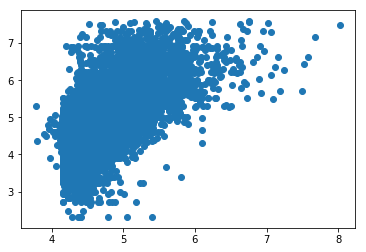

In [87]:
plt.scatter(predicted_vals, Y_val)
plt.show()

From the graph we know that the regression works also in the DNN Model. However, we did not find significant improvement using this model to make predictions. For log_price data between 4 and 6, this model is relatively able to use.

## Further Discussion

Comparing the three kinds of models, we first focus on the loss (measured by MSE) during each process. We found that the loss in model1 (model with Lasso Linear Regression) appears to be the smallest one (0.215), we could have a preference for this model.

Another advantage of model1 is that Lasso itself has a function of eliminating a certain amount of overfitting. We tried to apply cross-validation to our models and found that Lasso in model1 has the ability to decrease the overfitting effect.

Finally, when we use the neural network, there is no doubt that we should take the time factor into account. We need about 1.5 minutes on average to compute the linear regression models with the neural network, and we also need about 2000 steps to compute the DNN model. Nevertheless, we only have to compute the Lasso Linear Regression in a shorter period. Thus, model1 proves to be more efficient than the other two types of models with the neural network.

# Summary

Above all, we have used different methods to find a relatively optimized regression model. Each model has its strengths and weaknesses. We can use Lasso to make constraints to the overfitting problem or use Neural Network to train the data into useful sources to be utilized. In the question which we focus on, we found that using the model with Lasso is the optimized way to make predictions. 

On the other hand, it does not simply mean that we could ignore the usage of the Neural Network. We cannot say that one specific type of model is the "best" solution to solve our problem, and we should always try a variety of methods to solve the problems. After all, training the data makes a contribution to the optimization of the model and offers us essential thoughts about showing the value of the data.

# Reference

* Goodfellow, Bengio and Courville. Deep Learning. Cambridge, MA: MIT Press, 2017. 287.
* https://www.cntraveler.com/galleries/2016-06-22/places-with-strict-airbnb-laws
* https://medium.com/@nadimkawwa/boston-what-determines-airbnb-prices-d5bc670454b6
* https://scentellegher.github.io/programming/2017/07/15/pandas-groupby-multiple-columns-plot.html
* https://anujdutt9.github.io/LinearRegressionTF.html
* http://insideairbnb.com/get-the-data.html
* https://www.kaggle.com/stevezhenghp/airbnb-price-prediction
* https://www.kaggle.com/kpriyanshu256/airbnb-price
* https://www.kaggle.com/stevezhenghp/airbnb-price-prediction
* https://www.airbnb.com/help/article/2503/what-is-airbnb-and-how-does-it-work

